# Predicting Sales

### Workflow:

1. Feature Engineering
2. EDA
3. Model Building

Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pd.pandas.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import statistics

Import train.csv dataset

In [12]:
trainset=pd.read_csv('train.csv', parse_dates=['date'])
testset=pd.read_csv('test.csv', parse_dates=['date'])
gdpset=pd.read_csv('gdp.csv')
#trainset=trainset.append(testset)
#gdpset

In [13]:
trainset.head()

,row_id,date,country,store,product,num_sold,easter,newyear
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,0,1
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,0,1
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,0,1
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,0,1
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,0,1


#### Feature engineering

Going straight into feature engineering to extract time variables

In [14]:
def data_eng(data):
    df1=data.copy()

    for i in df1['country'].unique():
        df1[i]=np.where(df1['country']==i,1,0)

    for i in df1['store'].unique():
        df1[i]=np.where(df1['store']==i,1,0)

    for i in df1['product'].unique():
        df1[i]=np.where(df1['product']==i,1,0)

    df1['year']=df1['date'].dt.year
    df1['month']=df1['date'].dt.month 
    df1['week']=df1['date'].dt.isocalendar().week.astype(int) 
    df1['day']=df1['date'].dt.dayofyear
    df1['dayweek']=(df1['date'].dt.dayofweek)+1
    df1['daymonth']=df1['date'].dt.day

    dlist=['year','month','week','day','dayweek']
    df1=pd.merge(df1, gdpset, how="left", on=['year','country'])
    
    return df1

#### Kaggle's evaluation criteria

In [15]:
def smape(A, F):
    x= 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    #print (x)
    return x

In [16]:
df=data_eng(trainset)
df['num_sold_gdp']=df['num_sold']/df['gdp']
df.head(20)

,row_id,date,country,store,product,num_sold,easter,newyear,Finland,Norway,Sweden,KaggleMart,KaggleRama,Kaggle Mug,Kaggle Hat,Kaggle Sticker,year,month,week,day,dayweek,daymonth,gdp,num_sold_gdp
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,0,1,1,0,0,1,0,1,0,0,2015,1,1,1,4,1,234.440,1.403344
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,0,1,1,0,0,1,0,0,1,0,2015,1,1,1,4,1,234.440,2.218052
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,0,1,1,0,0,1,0,0,0,1,2015,1,1,1,4,1,234.440,0.622761
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,0,1,1,0,0,0,1,1,0,0,2015,1,1,1,4,1,234.440,2.439857
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,0,1,1,0,0,0,1,0,1,0,2015,1,1,1,4,1,234.440,3.885856
5,5,2015-01-01,Finland,KaggleRama,Kaggle Sticker,283,0,1,1,0,0,0,1,0,0,1,2015,1,1,1,4,1,234.440,1.207132
6,6,2015-01-01,Norway,KaggleMart,Kaggle Mug,526,0,1,0,1,0,1,0,1,0,0,2015,1,1,1,4,1,385.802,1.363394
7,7,2015-01-01,Norway,KaggleMart,Kaggle Hat,906,0,1,0,1,0,1,0,0,1,0,2015,1,1,1,4,1,385.802,2.348355
8,8,2015-01-01,Norway,KaggleMart,Kaggle Sticker,250,0,1,0,1,0,1,0,0,0,1,2015,1,1,1,4,1,385.802,0.648001
9,9,2015-01-01,Norway,KaggleRama,Kaggle Mug,1005,0,1,0,1,0,0,1,1,0,0,2015,1,1,1,4,1,385.802,2.604963


#### Defining predictor variables for model

In [21]:
X=[]
for feature in df.columns:
    if feature not in ['row_id','date','quarter','country','store','product','num_sold','num_sold_gdp','sales_prop','year','num_sold_gdp1','y_lag','dayweek1']:
        X.append(feature)
        
Y=['num_sold','num_sold_gdp','product','date','gdp']


#### Visualizing each products accross time

Using (num_sold / gdp) instead of num_sold has removed the upward trend, but seasonality effect still remains. <br>
Day of year variable ('day') to account for most of the seasonality within a year. <br>
Day of month variable ('daymonth') to account for most of the seasonality within a month. <br> 
Day of week variable ('dayweek') to account for most of the weekend and weekday effects. <br>

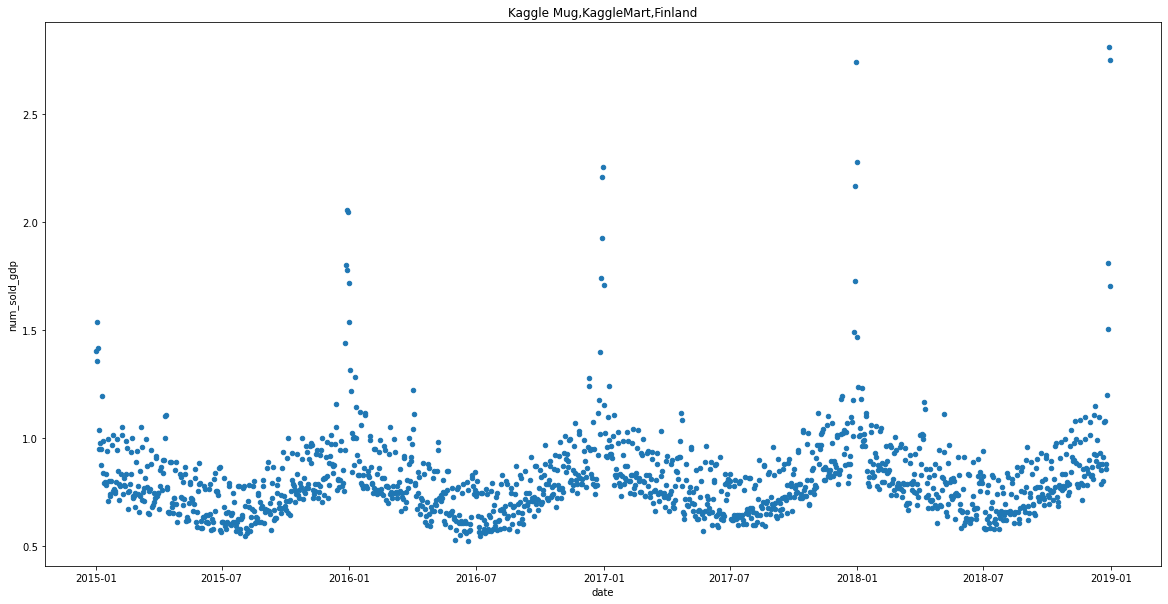

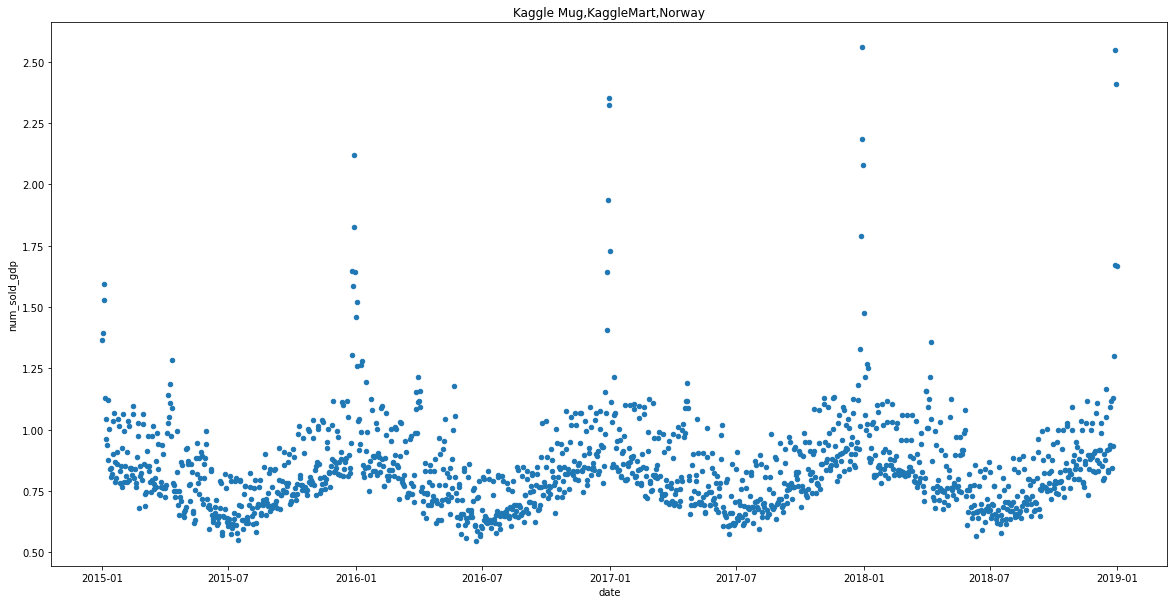

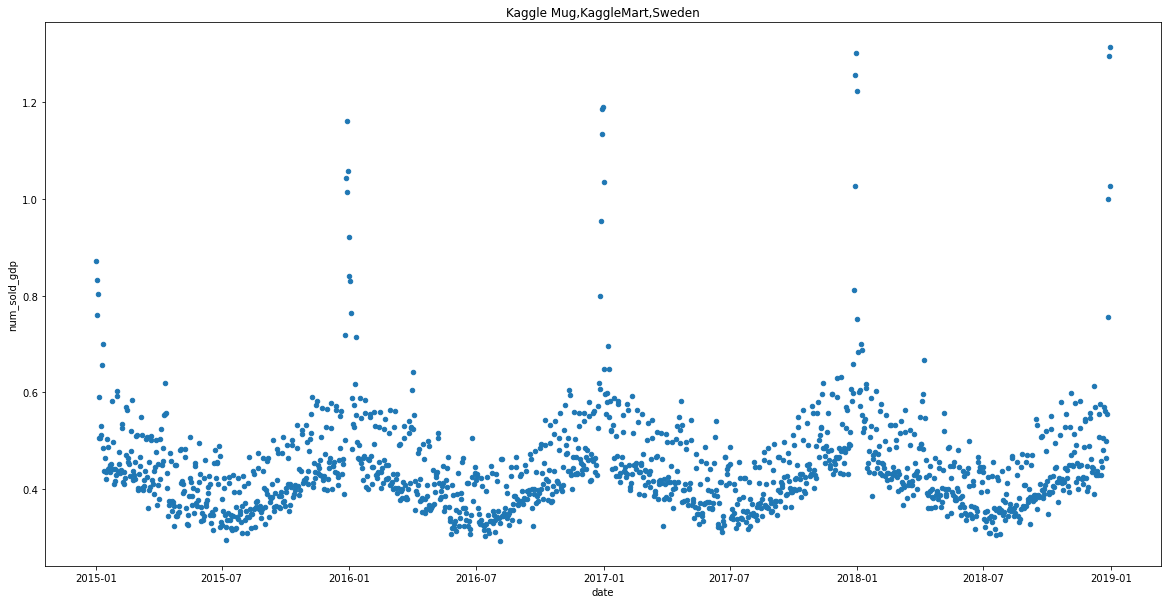

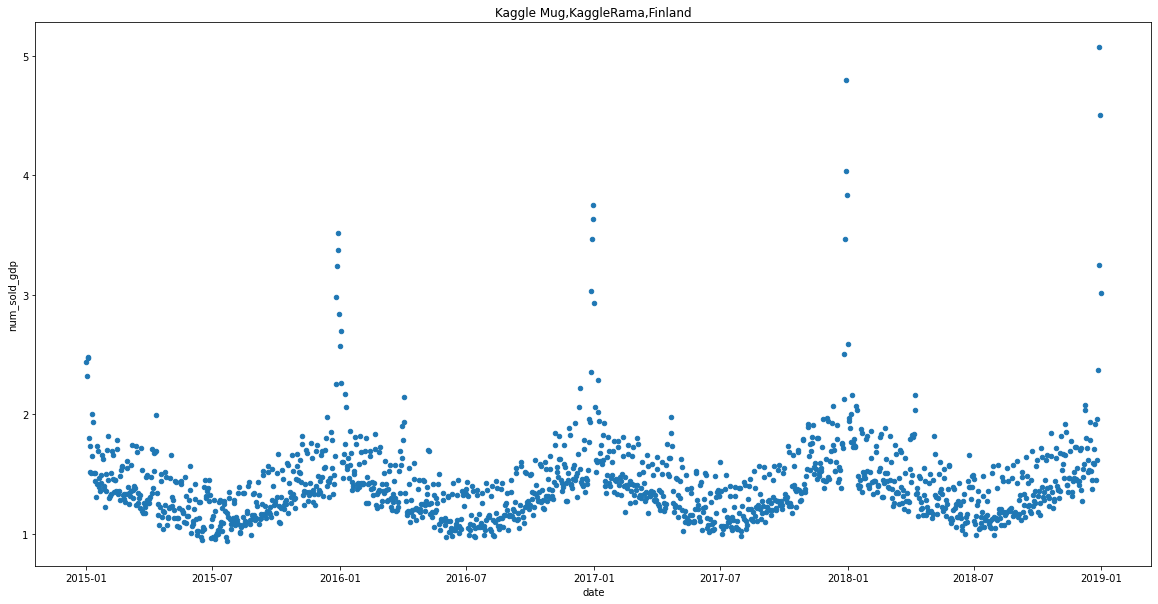

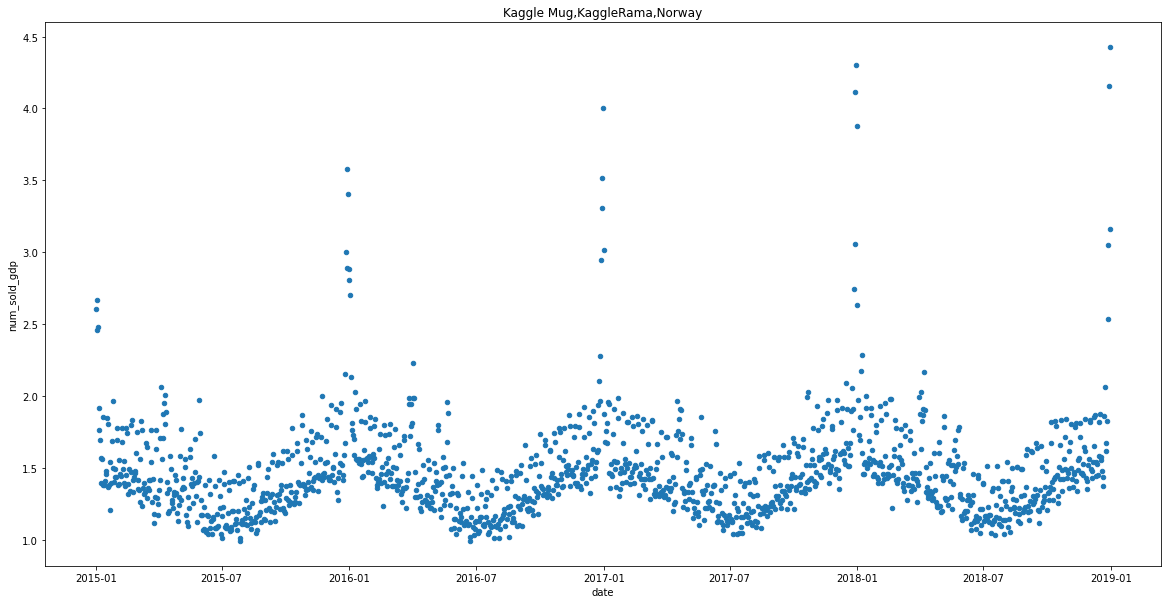

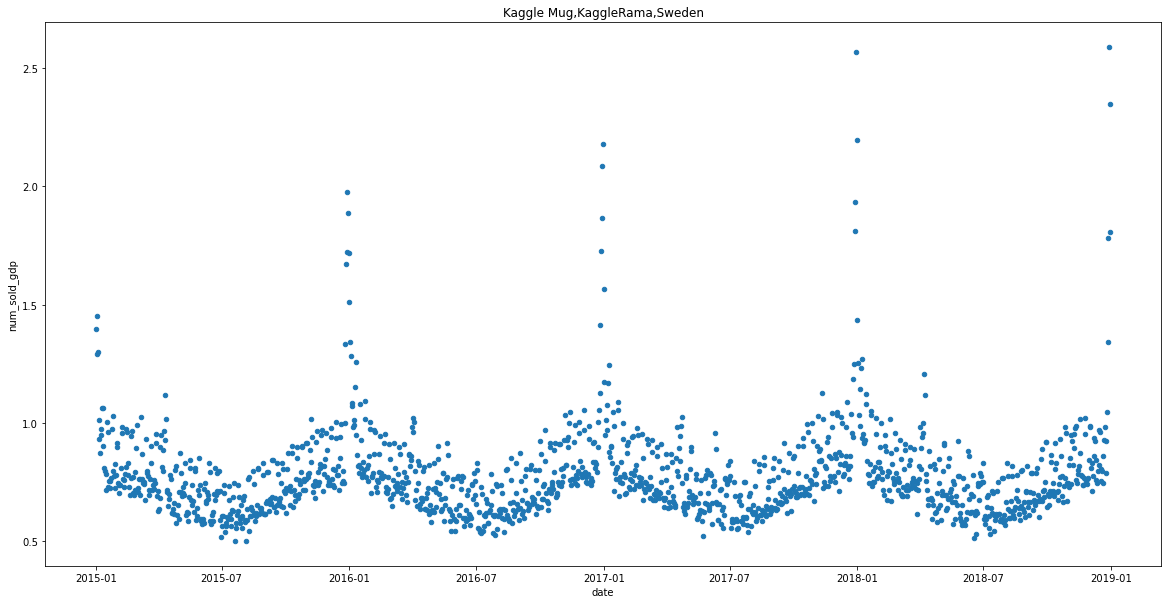

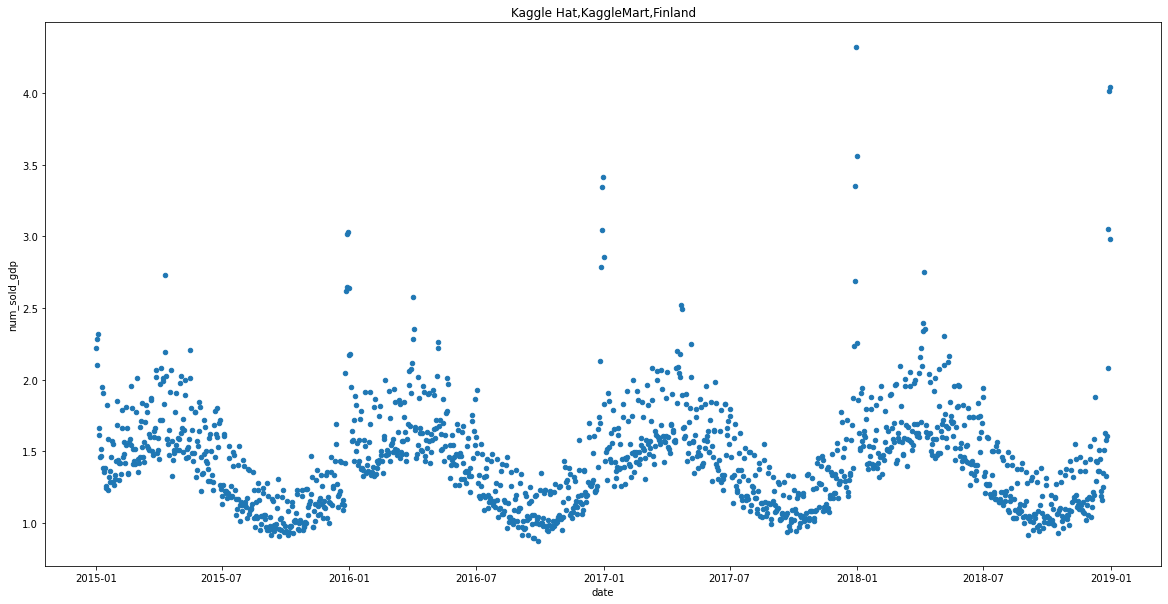

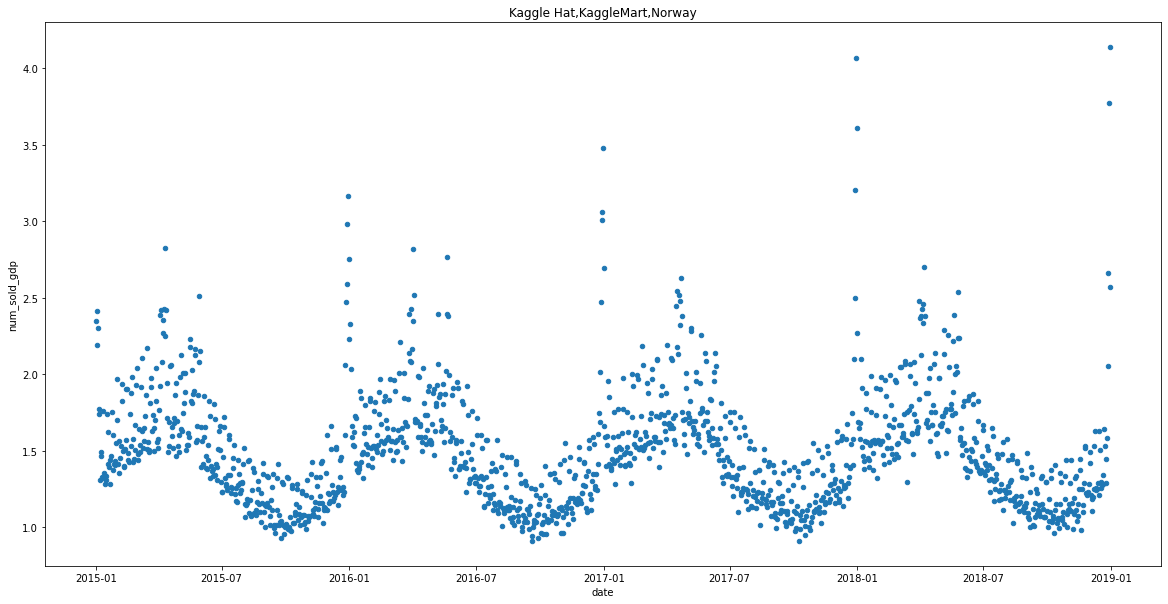

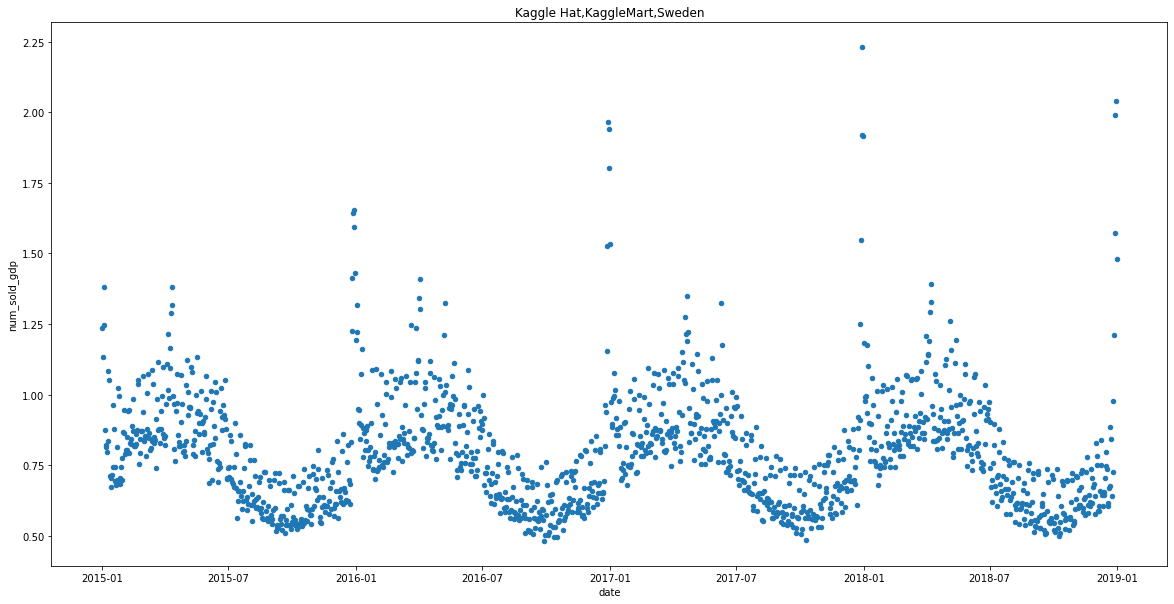

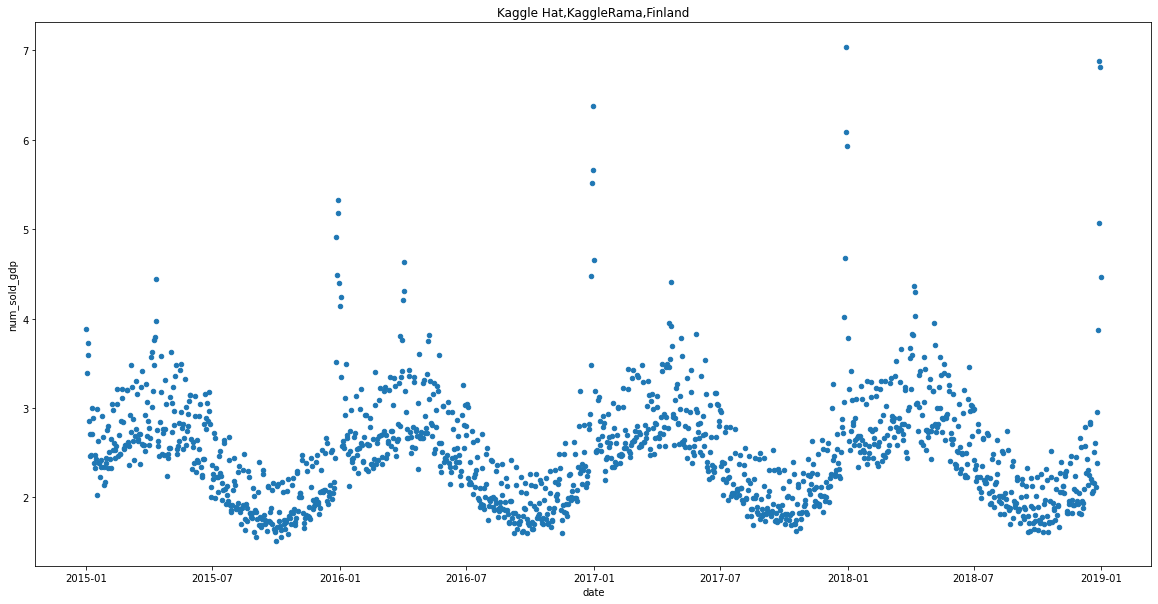

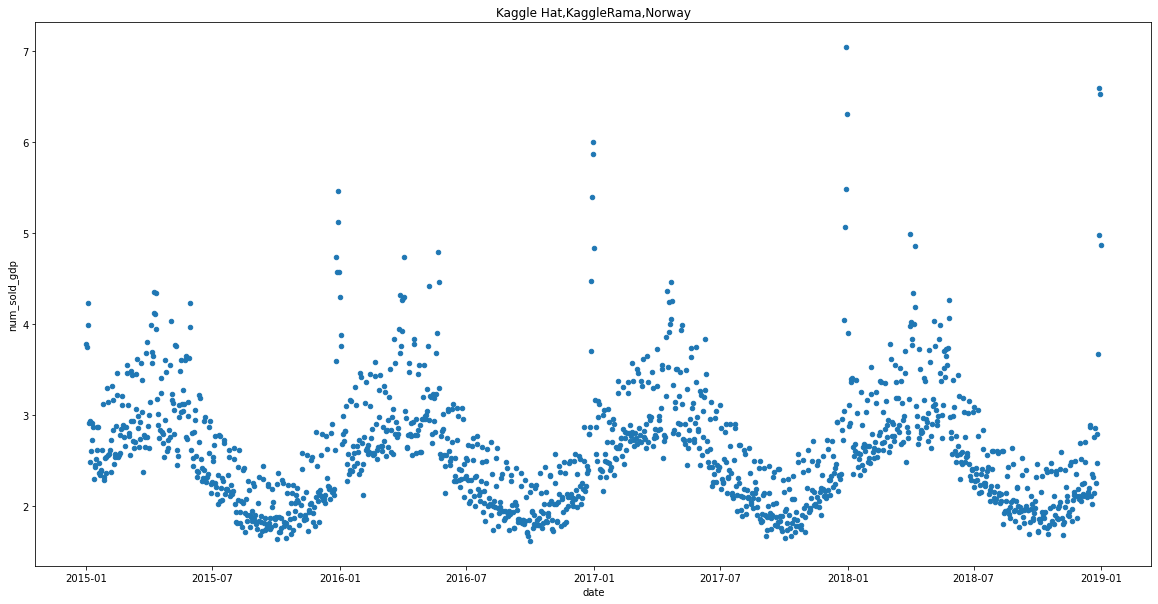

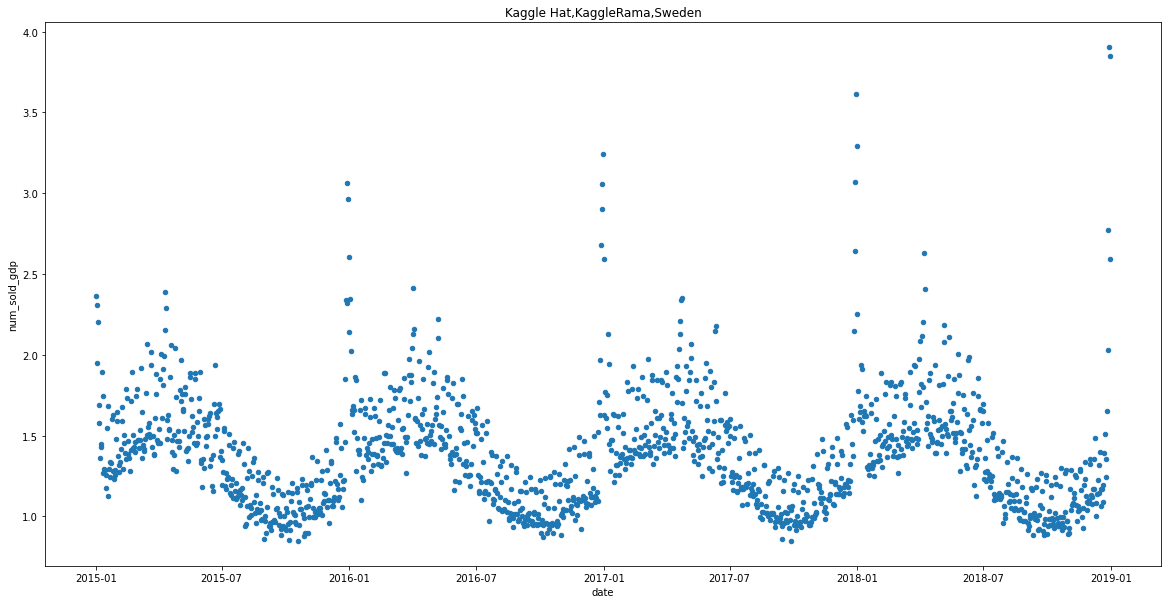

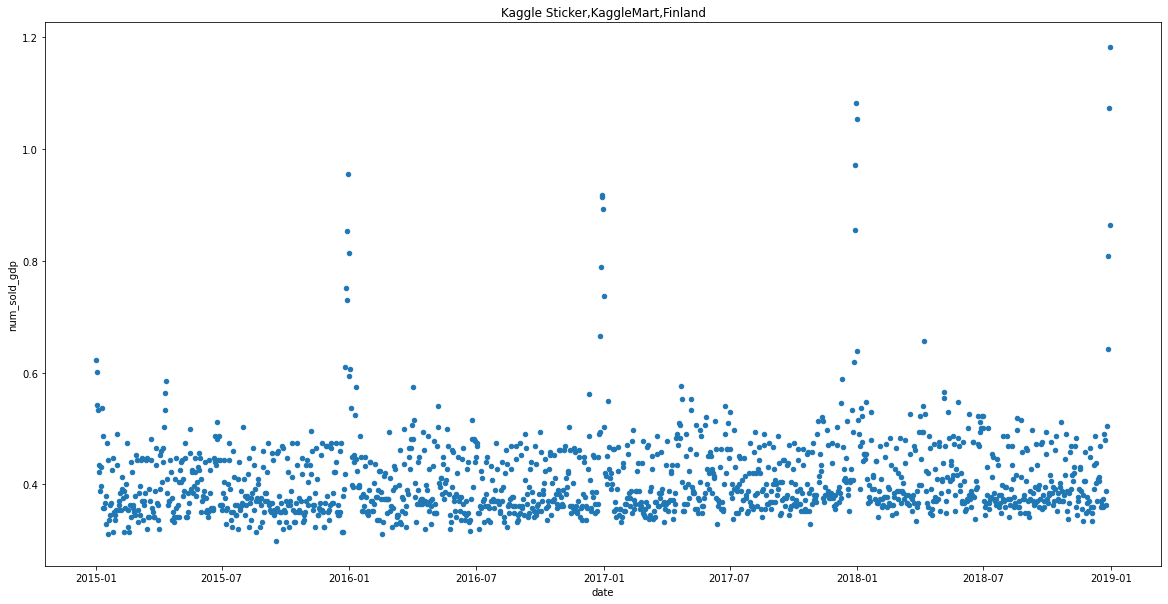

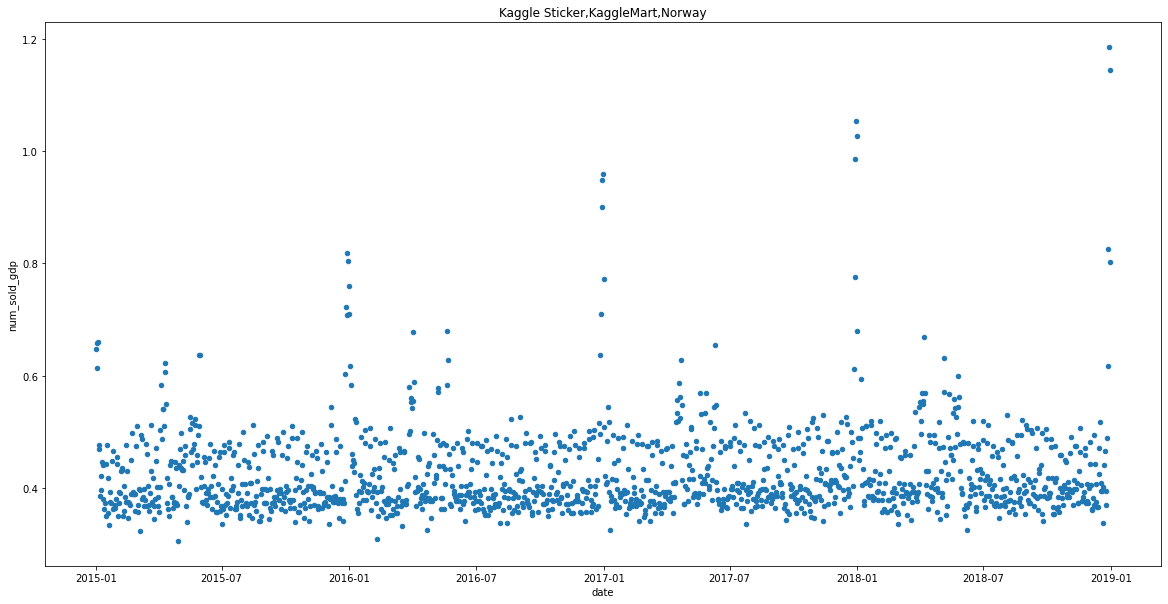

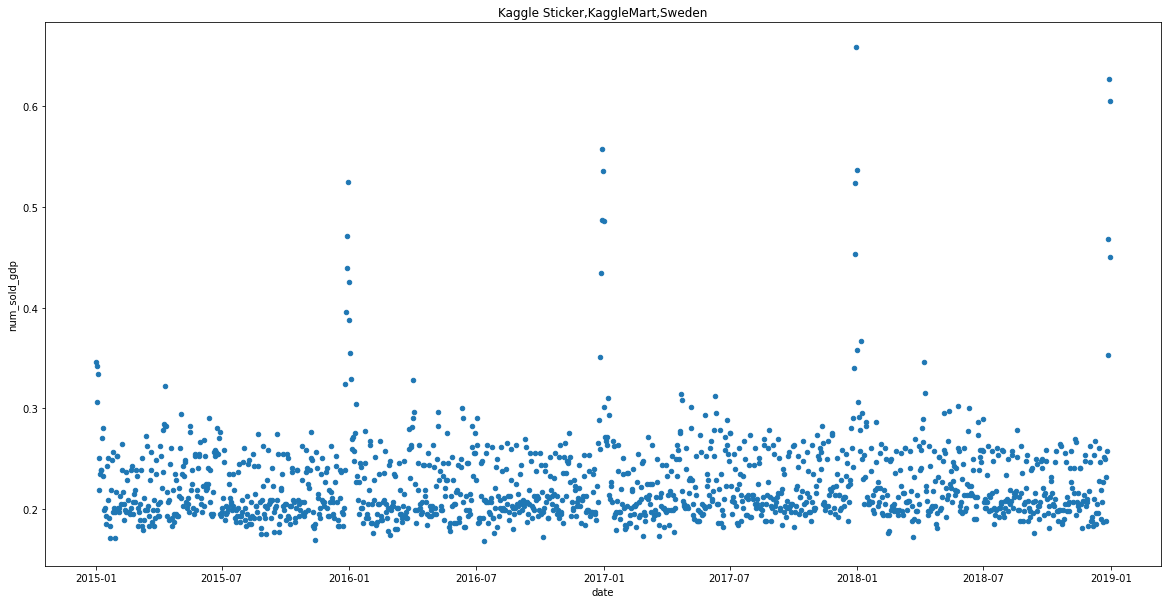

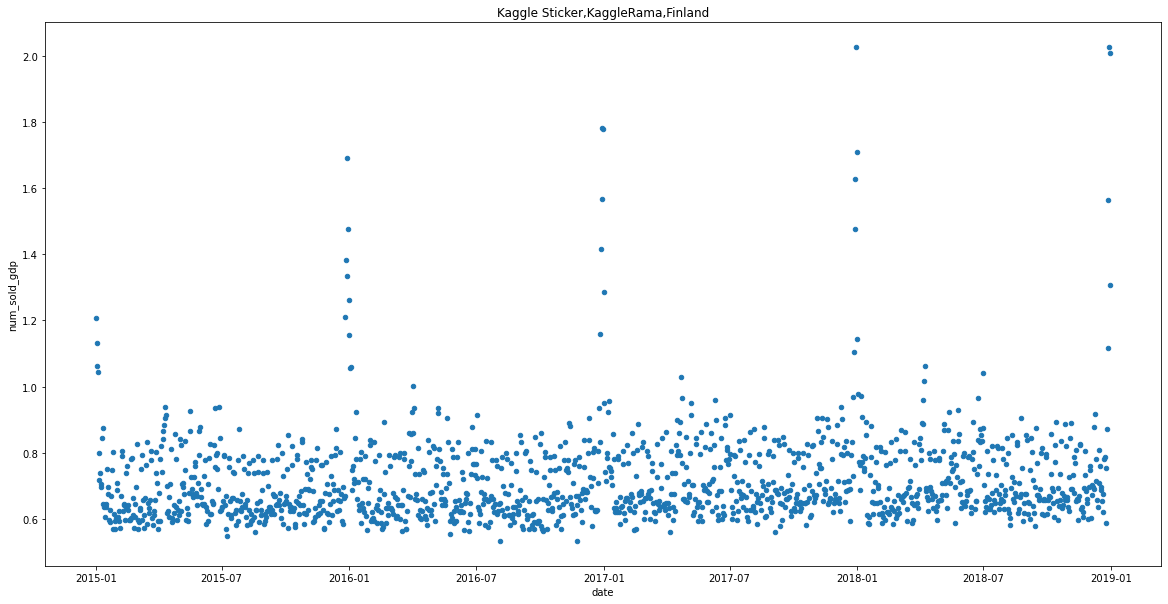

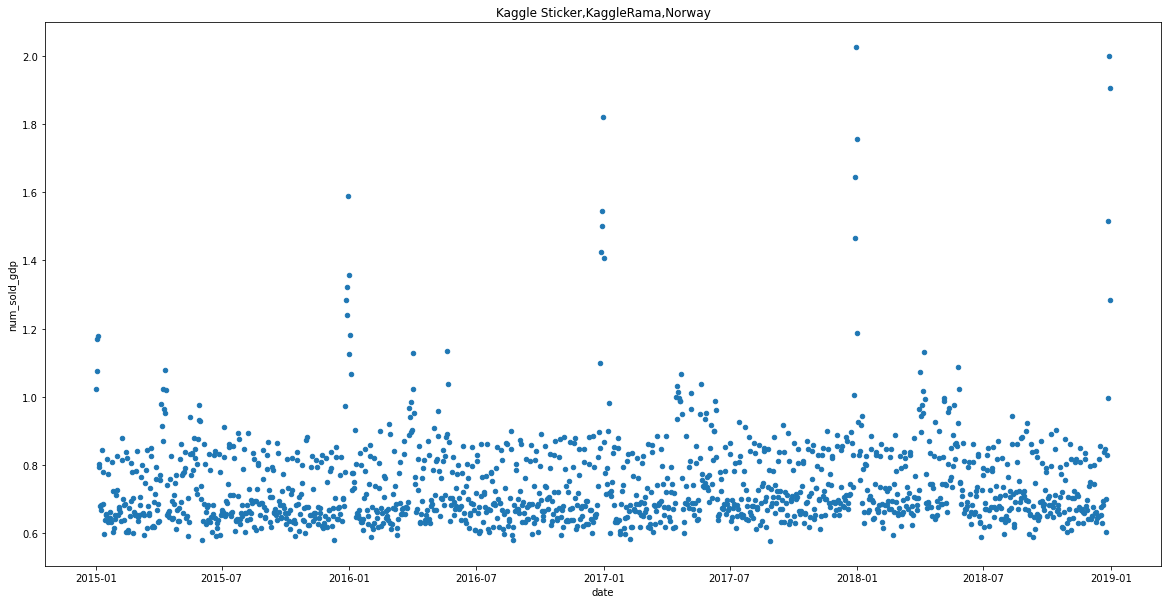

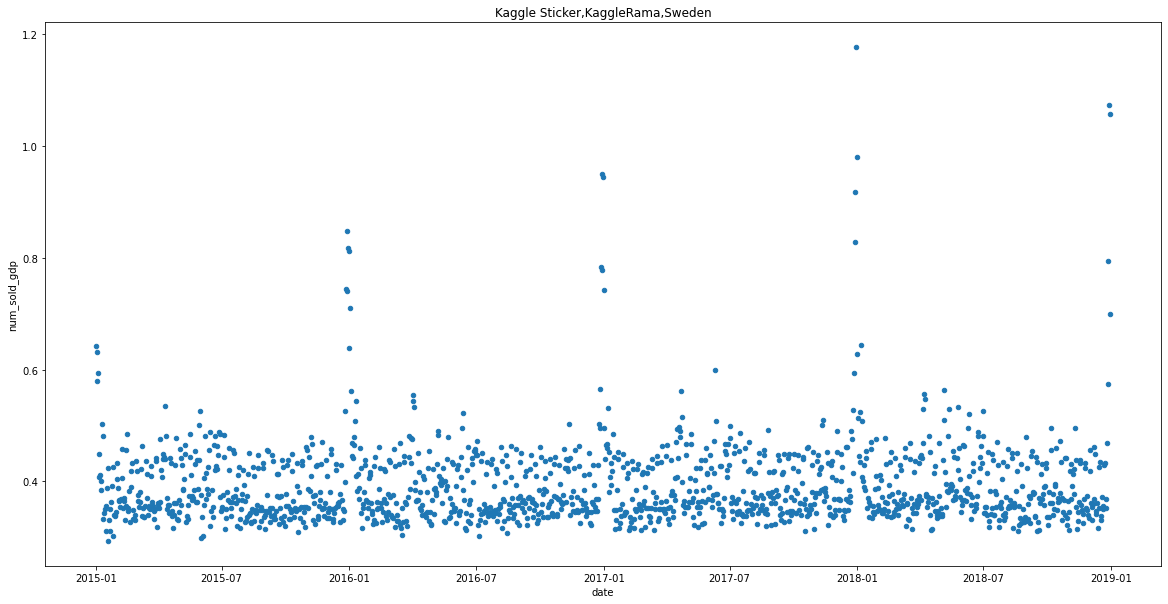

In [22]:
for product in df['product'].unique():
    viz=df[df['product']==product]
    for store in df['store'].unique():
        viz1=viz[viz['store']==store]
        for country in df['country'].unique():
            viz2=viz1[viz1['country']==country]
            #viz2=viz2[viz2['hol2']==0]
            #viz2=viz2[viz2['hol3']==0]
            #viz2=viz2[viz2['hol4']==0]
            viz2.plot.scatter(x='date',y='num_sold_gdp', figsize=(20,10), title='{},{},{}'.format(product, store, country))
            
            

In [23]:
df[X].head()

,easter,newyear,Finland,Norway,Sweden,KaggleMart,KaggleRama,Kaggle Mug,Kaggle Hat,Kaggle Sticker,month,week,day,dayweek,daymonth,gdp
0,0,1,1,0,0,1,0,1,0,0,1,1,1,4,1,234.44
1,0,1,1,0,0,1,0,0,1,0,1,1,1,4,1,234.44
2,0,1,1,0,0,1,0,0,0,1,1,1,1,4,1,234.44
3,0,1,1,0,0,0,1,1,0,0,1,1,1,4,1,234.44
4,0,1,1,0,0,0,1,0,1,0,1,1,1,4,1,234.44


#### Doing cross validation over different years.
Initial error plots showed much higher errors during March-April and New Year period.
It appears the model cannot account for that seasonality effect despite having day of year variable because the easter holiday season varies a lot accross the years. 
<br>
<br>
Dummy variables: 'easter' and 'newyear' variables, have been added to capture the holidays + (their respective weekends that also varies accross the years). These are the holidays that have more impact on the errors. The dummy variables successfully (not fully) reduced the errors.

SMAPE 2015: 5.224227135425146
SMAPE 2016: 5.107761850497028
SMAPE 2017: 5.231774497392761
SMAPE 2018: 4.97877319134224


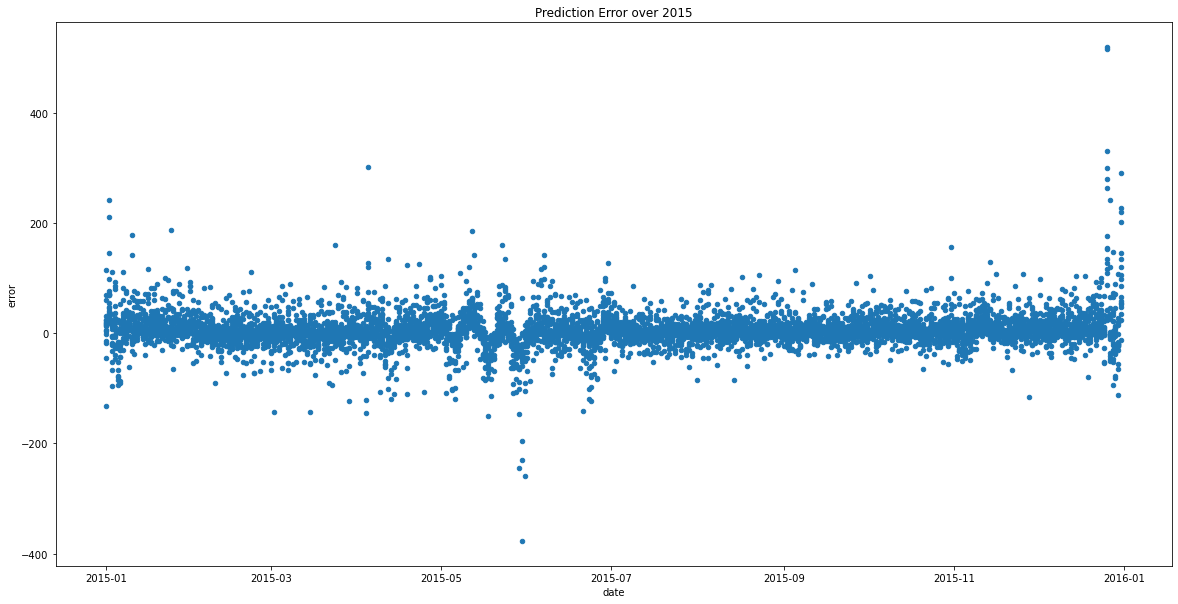

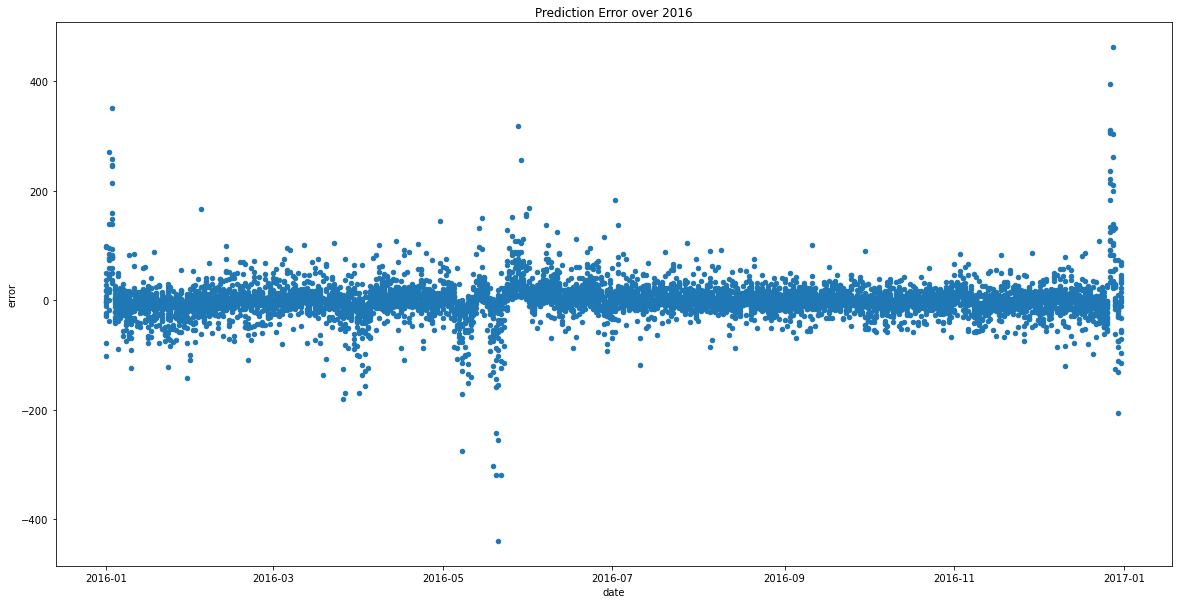

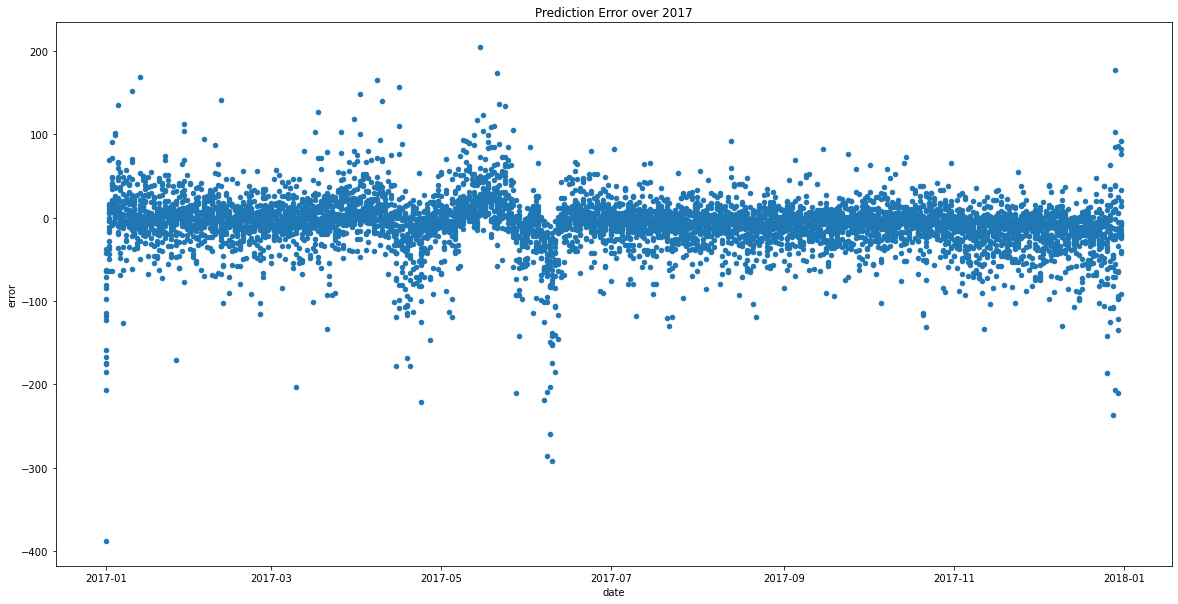

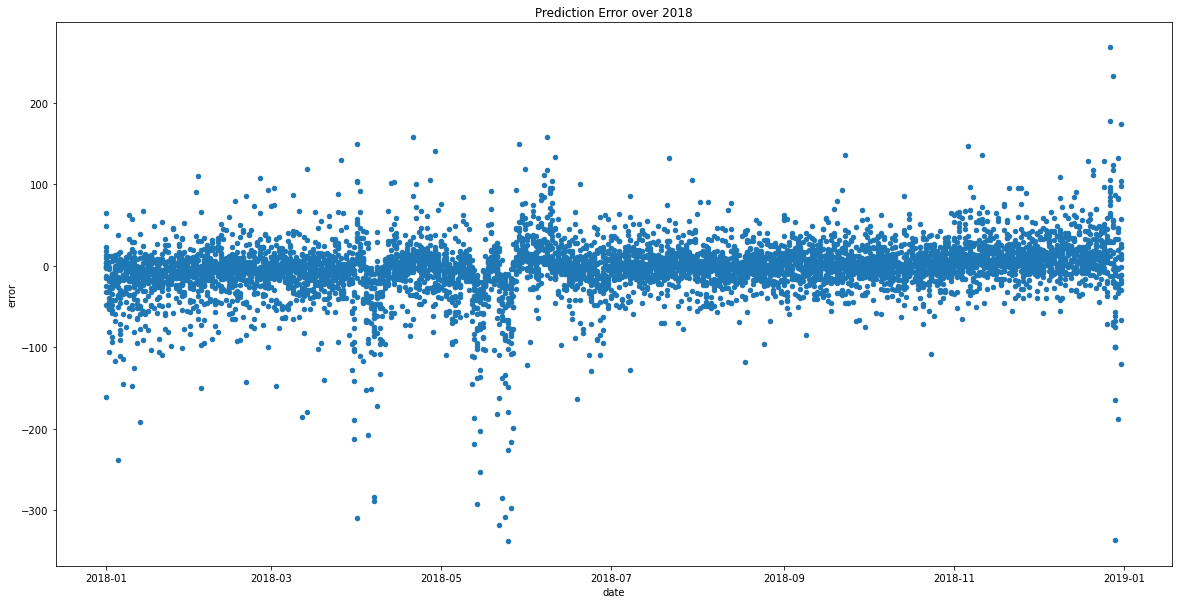

In [38]:
for yr in [2015,2016,2017,2018]:
    
    Xdf=df.copy()

    X_train=Xdf[Xdf['year']!=yr]
    X_test=Xdf[Xdf['year']==yr]
    y_train=df[df['year']!=yr]
    y_train=y_train[Y]
    y_test=df[df['year']==yr]
    y_test=y_test[Y]
    X_train=X_train[X]
    X_test=X_test[X]
    X_test
    
    reg3=XGBRegressor(eval_metric='rmse',max_depth=8,booster='gbtree', n_estimators=900, learning_rate=0.01, reg_alpha = 0.2)
    reg3.fit(X_train, y_train['num_sold_gdp'])
    ypred3=reg3.predict(X_test)

    #reg4=Ridge(alpha=0.2,random_state=0)
    #reg4=XGBRegressor(eval_metric='rmse',max_depth=10,booster='gbtree', n_estimators=1000, learning_rate=0.01, reg_alpha = 0.2)
    #reg4.fit(X_train, y_train['num_sold_gdp'])
    #ypred4=reg4.predict(X_test)

    #reg6=XGBRegressor(eval_metric='rmse',max_depth=10,booster='gbtree', n_estimators=900, learning_rate=0.01, reg_alpha = 0.2)
    #reg6.fit(X_train, y_train['num_sold_gdp'])
    #ypred6=reg6.predict(X_test)

    #model = CatBoostRegressor(depth= 8, learning_rate=0.01, iterations=10000, bootstrap_type='Bayesian',boosting_type='Plain',loss_function='MAE', eval_metric='SMAPE',random_seed=5)
    #model.fit(X_train, y_train['num_sold_gdp'])
    #ypredcat=model.predict(X_test)

    #ypred=(0.5*ypred3)+(0.5*ypred4)

    y_table=y_test
    y_table['predict']=y_table['gdp']*ypred3
    #y_table['predict2']=y_table['gdp']*ypred6
    #y_table['predict3']=y_table['gdp']*ypred
    #y_table['predict4']=y_table['gdp']*ypred4
   
    print (f'SMAPE {yr}:',smape(y_table['num_sold'],y_table['predict'])) #,smape(y_table['num_sold'],y_table['predict2']),smape(y_table['num_sold'],y_table['predict3']),smape(y_table['num_sold'],y_table['predict4']))
    y_table['error']=y_table['predict']-y_table['num_sold']
    y_table.plot.scatter(x='date',y='error',figsize=(20,10), title=f'Prediction Error over {yr}')
    
    

### Submission

In [30]:
trainset=pd.read_csv('train.csv', parse_dates=['date'])
testset=pd.read_csv('test.csv', parse_dates=['date'])
gdpset=pd.read_csv('gdp.csv')
trainset=trainset.append(testset)

In [31]:
df=data_eng(trainset)
df['num_sold_gdp']=df['num_sold']/df['gdp']

df_test=df[df['year']==2019]
df=df[df['year']<2019]
df.head()

,row_id,date,country,store,product,num_sold,easter,newyear,Finland,Norway,Sweden,KaggleMart,KaggleRama,Kaggle Mug,Kaggle Hat,Kaggle Sticker,year,month,week,day,dayweek,daymonth,gdp,num_sold_gdp
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0,0,1,1,0,0,1,0,1,0,0,2015,1,1,1,4,1,234.44,1.403344
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0,0,1,1,0,0,1,0,0,1,0,2015,1,1,1,4,1,234.44,2.218052
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146.0,0,1,1,0,0,1,0,0,0,1,2015,1,1,1,4,1,234.44,0.622761
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572.0,0,1,1,0,0,0,1,1,0,0,2015,1,1,1,4,1,234.44,2.439857
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911.0,0,1,1,0,0,0,1,0,1,0,2015,1,1,1,4,1,234.44,3.885856


In [32]:
df_test.head()

,row_id,date,country,store,product,num_sold,easter,newyear,Finland,Norway,Sweden,KaggleMart,KaggleRama,Kaggle Mug,Kaggle Hat,Kaggle Sticker,year,month,week,day,dayweek,daymonth,gdp,num_sold_gdp
26298,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug,NaN,0,1,1,0,0,1,0,1,0,0,2019,1,1,1,2,1,268.782,NaN
26299,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat,NaN,0,0,1,0,0,1,0,0,1,0,2019,1,1,1,2,1,268.782,NaN
26300,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker,NaN,0,0,1,0,0,1,0,0,0,1,2019,1,1,1,2,1,268.782,NaN
26301,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug,NaN,0,0,1,0,0,0,1,1,0,0,2019,1,1,1,2,1,268.782,NaN
26302,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat,NaN,0,0,1,0,0,0,1,0,1,0,2019,1,1,1,2,1,268.782,NaN


In [33]:
X_train=df[X]
y_train=df['num_sold_gdp']
X_test=df_test[X]
y_test=df_test[['row_id','gdp']]

In [34]:
reg3=XGBRegressor(eval_metric='rmse',max_depth=8,booster='gbtree', n_estimators=900, learning_rate=0.01, reg_alpha = 0.2)
reg3.fit(X_train, y_train)
ypred3=reg3.predict(X_test)
y_test['num_sold']=y_test['gdp']*ypred3

<ipython-input-34-c4d05022fe46>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['num_sold']=y_test['gdp']*ypred3


In [35]:
y_test.isnull().sum()

row_id      0
gdp         0
num_sold    0
dtype: int64

In [36]:
y_test=y_test[['row_id','num_sold']]
y_test.to_csv('submission2.csv', index=False)
y_test

,row_id,num_sold
26298,26298,399.491133
26299,26299,479.839783
26300,26300,142.701315
26301,26301,535.229951
26302,26302,834.591762
...,...,...
32863,32863,791.470395
32864,32864,263.511511
32865,32865,978.355010
32866,32866,1390.606448
